In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ssm
from ssm import transitions 
import csv
import scipy.io

In [2]:
# load data
filename = 'C:/Users/Asus/Desktop/PhD/rotations/AnnJeff/data/data/animalspaper.mat'
data = scipy.io.loadmat(filename)
data = data['riskydata']
header =  ['animal0', 'sessionid1', 'trialnumber2', 'trial_block3', 'lotterymag4', 'lotteryprob5', 
           'surebetmag6', 'rewardreceived7', 'lotterychoice8', 'lotteryoutcome9']

In [254]:
# defining psychometric curve function
def psycurves(x, u, l, b, s):
  """ 4-parameters psychometric function

  Args:
    x (ndarray): data to fit
    u (float): upper assymptote (lim psycurve when (stim -> +inf))
    l (float): lower assymptote (lim psycurve when (stim -> -inf))
    b (float): bias (stim value where psycurve crosses chance level)
    s (float): slope  

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
    
  return (u-l)*((np.exp((x-b)/s))/(1 + np.exp((x-b)/s))) + l

In [255]:
animalid = np.unique(data[:,0])
nstim = len(np.unique(data[:,4]))
nanimals = len(animalid)

plottery = []
deltaEV = []
for aa in range(nanimals):
    animalflags = data[:,0] == animalid[aa]
    
    sessions = np.unique(data[animalflags, 1])
    nsessions = len(sessions)

    plottery.append(np.zeros([nsessions, nstim]))
    deltaEV.append(np.zeros([nsessions, nstim]))
    for ss in range(nsessions):
        sessionflags = data[:,1] == sessions[ss]
        ss_data = data[animalflags & sessionflags, :]
        
        surebet_flags = ss_data[:, 8] == 0
        surebet_mag = np.unique(ss_data[surebet_flags, 6])
        surebet_rwd = np.unique(ss_data[surebet_flags, 7])
        rwdmultiplier = surebet_rwd/surebet_mag
        
        lotteryprob = np.unique(ss_data[:,5])
        lotterymag = np.unique(ss_data[:,4])
        rwdreceived = np.unique(ss_data[:,7])

        if(len(lotterymag)<nstim):
            continue;
        
        deltaEV[aa][ss,:] = np.round((rwdmultiplier * (lotterymag * lotteryprob)) - surebet_rwd, 1)

        for ev in range(nstim):
            magnitudeflags = ss_data[:, 4] == lotterymag[ev]
            lotterychoiceflags = ss_data[magnitudeflags, 8] == 1
            plottery[aa][ss, ev] = sum(lotterychoiceflags)/sum(magnitudeflags)


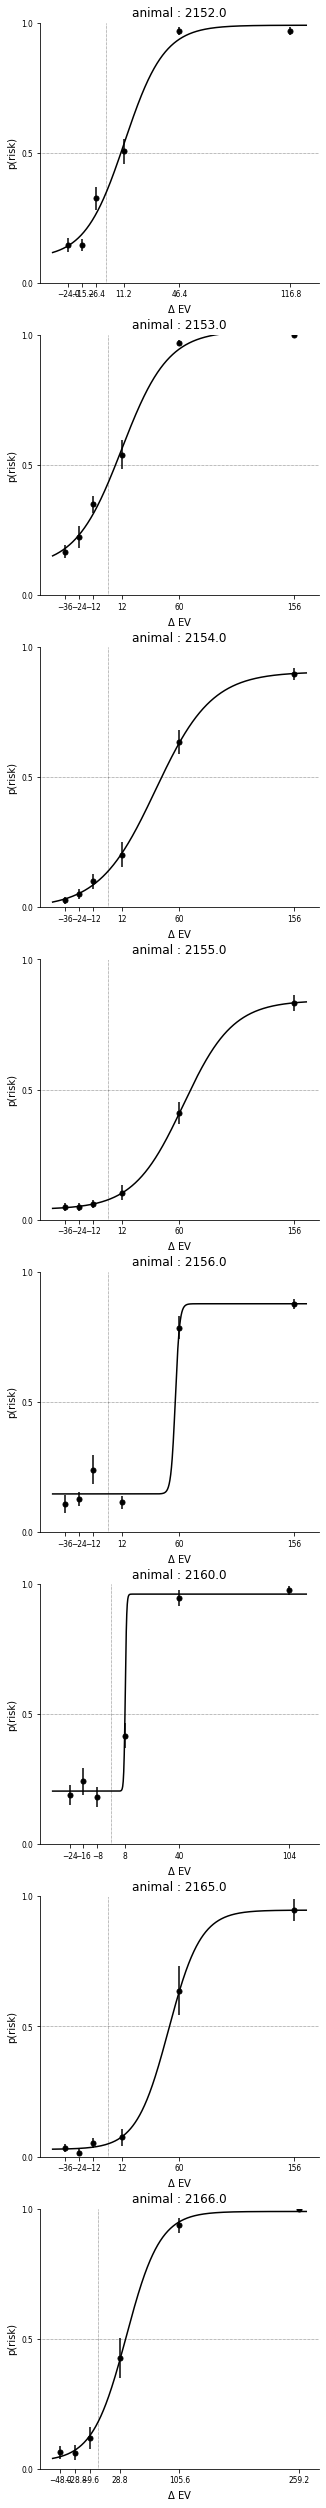

In [175]:
# plot psychometric curves
fig, ax = plt.subplots(nanimals, 1, figsize = (5, 45))
for aa in range(nanimals):
    lotterymag = np.unique(deltaEV[aa])
    nsessions = plottery[aa].shape[0]
    lotterymean =  np.mean(plottery[aa], 0)
    lotterysem =  np.std(plottery[aa], 0)/np.sqrt(nsessions)
    
    plt.subplot(nanimals, 1, aa + 1)
    plt.errorbar(lotterymag, lotterymean, lotterysem,
                marker = 'o', linestyle = 'None', 
                markerfacecolor = 'k', markeredgecolor = 'k',
                ecolor = 'k', markersize = 5)
    
    popt, _ = curve_fit(psycurves, lotterymag, lotterymean)
    xx = np.linspace(min(lotterymag) - 10, max(lotterymag) + 10, 1000)
    plt.plot(xx, psycurves(xx, *popt), c = 'k')
    
    # reference lines
    plt.axvline(0, linestyle = ':', c = 'k',  lw = .5)
    plt.axhline(.5, linestyle = ':', c = 'k', lw = .5)
    
    # axis options
    plt.ylim((0,1))
    plt.xlabel('$\Delta$ EV')  
    plt.title('animal : ' + str(animalid[aa]))
    plt.ylabel('p(risk)')
    ax[aa].set_yticks([0, .5, 1])
    ax[aa].set_xticks(lotterymag)
    plt.xticks(fontsize = 7.5)
    plt.yticks(fontsize = 7.5)
    ax[aa].spines['top'].set_visible(False)
    ax[aa].spines['right'].set_visible(False)


In [335]:
# getting data for a specific animal (glmhmmtest)
animalflags = data[:,0] == animalid[0]
sessions = np.unique(data[animalflags, 1])
nsessions = len(sessions)

Y = []
inputs = []
tt_deltaEV = []
for ss in range(nsessions):
    sessionflags = data[:, 1] == sessions[ss]
    ntrials = sum(sessionflags)
    
    Y.append(np.zeros([ntrials,1], dtype = int))
    inputs.append(np.ones([ntrials, 2]))
    tt_deltaEV.append(np.zeros([ntrials,1]))
    
    ss_data = data[animalflags & sessionflags, :]
    choice = ss_data[:,8]
    lotterymag = ss_data[:,4]
    
    # session specific settings
    surebet_flags = ss_data[:, 8] == 0
    surebet_mag = np.unique(ss_data[surebet_flags, 6])
    surebet_rwd = np.unique(ss_data[surebet_flags, 7])
    rwdmultiplier = surebet_rwd/surebet_mag
    lotteryprob = np.unique(ss_data[:,5])
    ss_lotterymag = np.unique(ss_data[:,4])
    
    ss_deltaEV = np.round((rwdmultiplier * (lotterymag * lotteryprob)) - surebet_rwd, 1)
   
    for tt in range(ntrials):
        Y[ss][tt][0] = choice[tt]
        getdeltaEV = np.round((rwdmultiplier * (lotterymag[tt] * lotteryprob)) - surebet_rwd,1)
        tt_deltaEV[ss][tt] = getdeltaEV
        inputs[ss][tt][0] = (getdeltaEV - np.mean(ss_deltaEV))/(np.std(ss_deltaEV))    

  0%|          | 0/200 [00:00<?, ?it/s]

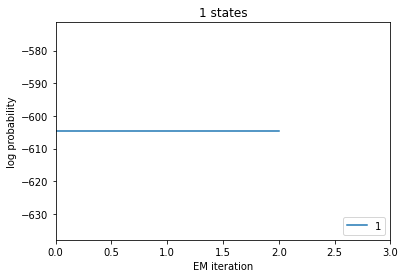

  0%|          | 0/200 [00:00<?, ?it/s]

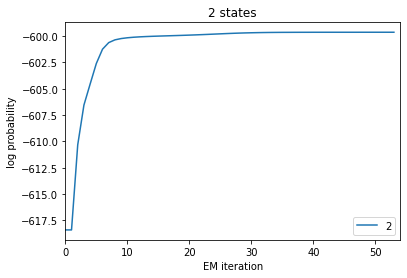

  0%|          | 0/200 [00:00<?, ?it/s]

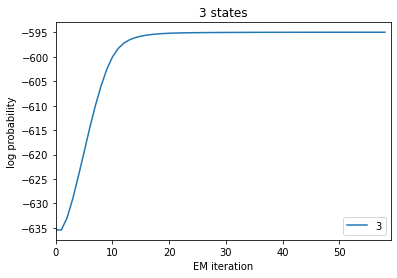

  0%|          | 0/200 [00:00<?, ?it/s]

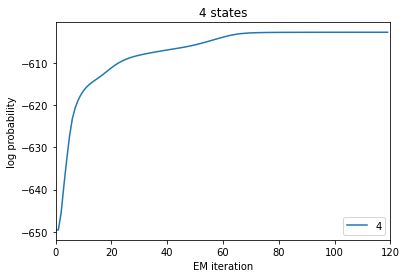

  0%|          | 0/200 [00:00<?, ?it/s]

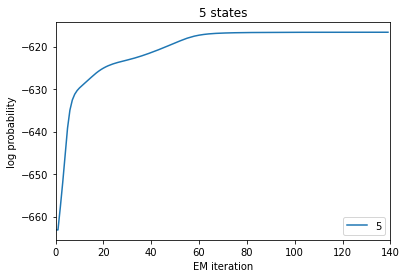

In [336]:
# setting glm-hmm parameters
nstates = np.array([1,2,3,4,5])
obsdim = 1
inputdim = 2
ncatergories = 2
niterations = 200
fig = plt.figure()
for kk in nstates:
    glmhmm = ssm.HMM(kk, obsdim, inputdim,  observations = 'input_driven_obs',
                observation_kwargs = dict(C = ncatergories), transitions = "standard")

    glmhmm2fit = glmhmm.fit(Y, inputs = inputs, method = 'em', num_iters = niterations, tolerance = 10**-5)

    # plot LL convergence
    plt.plot(glmhmm2fit, label = str(kk))

    # axis options
    plt.title(str(kk) + ' states')
    plt.legend(loc = 'lower right')
    plt.xlabel('EM iteration')
    plt.xlim(0, len(glmhmm2fit))
    plt.ylabel('log probability')
    plt.show()


  0%|          | 0/150 [00:00<?, ?it/s]

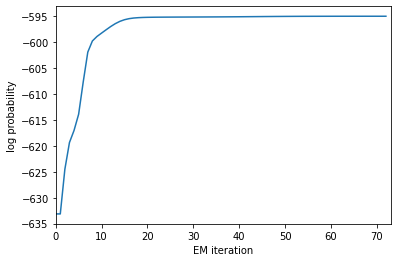

In [337]:
# setting glm-hmm parameters
nstates = 3
obsdim = 1
inputdim = 2
ncatergories = 2
niterations = 150

glmhmm = ssm.HMM(nstates, obsdim, inputdim,  observations = 'input_driven_obs',
                observation_kwargs = dict(C = ncatergories), transitions = "standard")

glmhmm2fit = glmhmm.fit(Y, inputs = inputs, method = 'em', num_iters = niterations, tolerance = 10**-5)

# plot LL convergence
plt.plot(glmhmm2fit)

# axis options
plt.xlabel('EM iteration')
plt.xlim(0, len(glmhmm2fit))
plt.ylabel('log probability')
plt.show()

Text(0.5, 1.0, 'transition matrix')

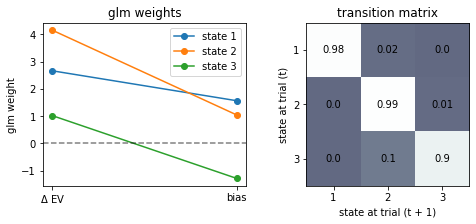

In [338]:
# plot glm weights for each covariate
fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
for kk in range(nstates):
    plt.plot(range(inputdim), glmhmm.observations.params[kk][0]*(-1), marker = 'o', linestyle='-', label = 'state ' + str(kk+1))

plt.ylabel('glm weight')
plt.xticks([0, 1], ['$\Delta$ EV', 'bias'])
plt.axhline(y = 0, color = 'k', alpha = .5, ls = '--')
plt.legend()
plt.title('glm weights')

# plot transition matrix
plt.subplot(1, 2, 2)
transmat = np.round(glmhmm.transitions.transition_matrix, 2)
plt.imshow(transmat, vmin = -.8, vmax = 1, cmap = 'bone')

for ii in range(nstates):
    for jj in range(nstates):
        text = plt.text(jj, ii, str(transmat[ii, jj]), ha = 'center', va = 'center', color = 'k')

plt.xlim(-.5, nstates - .5)
plt.xticks(range(0, nstates), ('1', '2', '3'))
plt.yticks(range(0, nstates), ('1', '2', '3'))
plt.ylim(nstates - .5, -.5)
plt.ylabel('state at trial (t)')
plt.xlabel('state at trial (t + 1)')
plt.title('transition matrix')

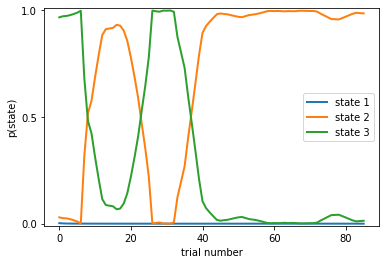

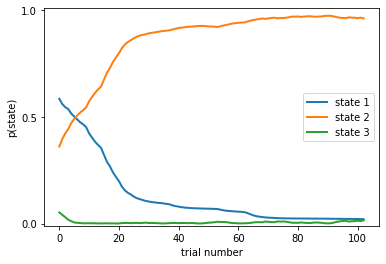

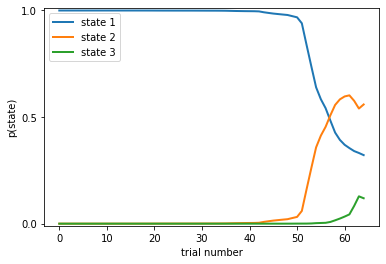

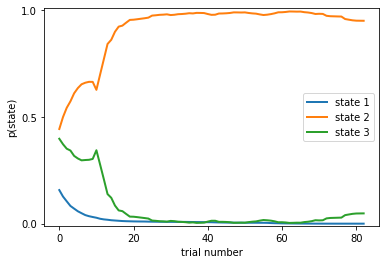

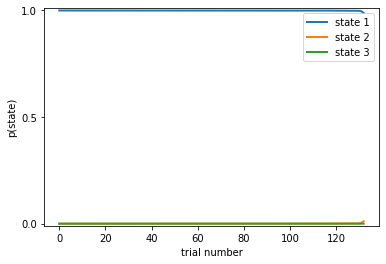

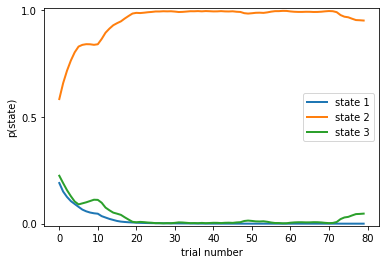

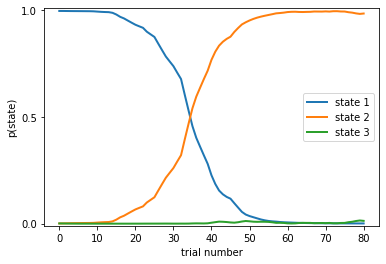

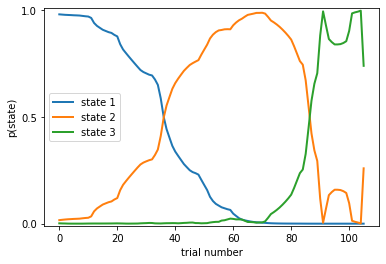

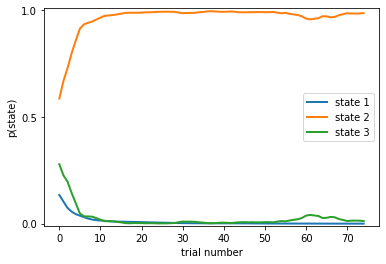

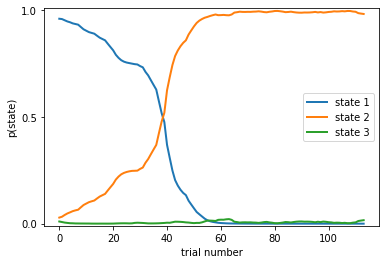

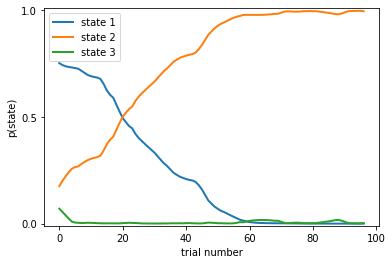

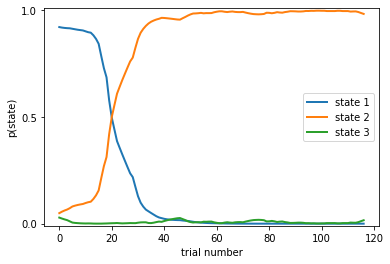

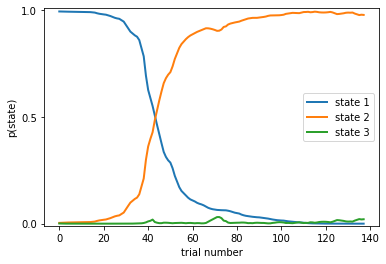

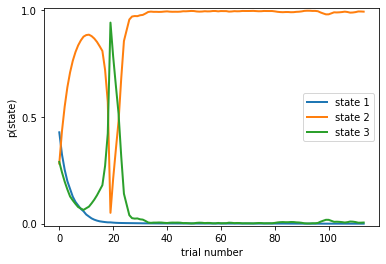

In [339]:
# get expected states
posterior_pstate = [glmhmm.expected_states(data = data, input = inputs)[0]
                    for data, inputs
                    in zip(Y, inputs)]

for ss in range(nsessions):
    plt.figure()
    for kk in range(nstates):
        plt.plot(posterior_pstate[ss][:, kk], label = 'state ' + str(kk + 1), lw = 2)

    plt.ylim((-0.01, 1.01))
    plt.yticks([0, 0.5, 1])
    plt.xlabel("trial number")
    plt.ylabel("p(state)")
    plt.legend()

In [340]:
# getting states
sessions = np.unique(data[animalflags, 1])
nsessions = len(sessions)
Z = []
for ss in range(nsessions):
    sessionflags = data[:, 1] == sessions[ss]
    ntrials = sum(sessionflags)
    posteriors = posterior_pstate[ss]
    Z.append(np.zeros([ntrials, 1], dtype = int))
    
    for tt in range(ntrials):
        Z[ss][tt] = np.where(posteriors[tt,:] == max(posteriors[tt,:]))

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if sys.path[0] == '':


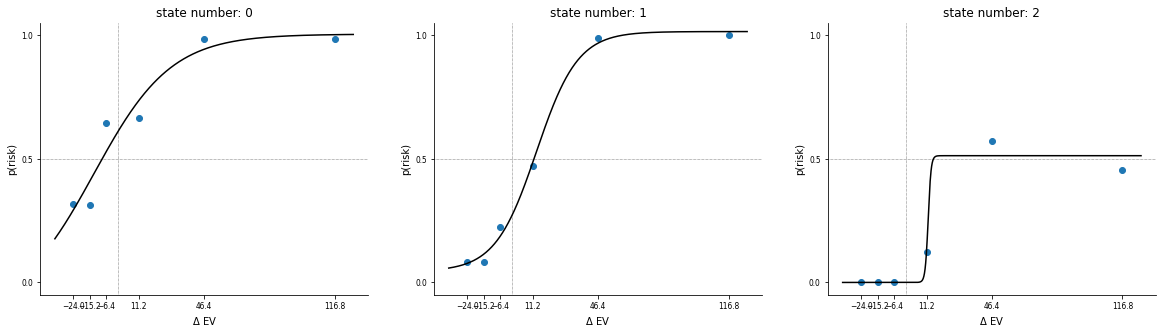

In [341]:
# session stack to make psychometrics
statesflat = np.array([item for sublist in Z for item in sublist])
evsflat = np.array([item for sublist in tt_deltaEV for item in sublist])
choicesflat = data[animalflags, 8]
nstim = np.unique(evsflat).shape[0]

fig, ax = plt.subplots(1, nstates, figsize = (20, 5))

plottery = np.zeros([nstim, nstates])
for zz in range(nstates):
    stateflags = statesflat[:,0] == zz
    
    for st in range(nstim):
        stimflags = evsflat[:,0] == np.unique(evsflat)[st]
        
        lotterychoices = choicesflat[stateflags & stimflags]
        plottery[st,zz] = np.mean(lotterychoices)
        
    # plot psychometric curves
    plt.subplot(1, nstates, zz + 1)
    plt.scatter(np.unique(evsflat), plottery[:,zz])
    
    popt, _ = curve_fit(psycurves, np.unique(evsflat), plottery[:,zz], xtol = 1e-5)
    xx = np.linspace(min(np.unique(evsflat)) - 10, max(np.unique(evsflat)) + 10, 1000)
    plt.plot(xx, psycurves(xx, *popt), c = 'k')
    
    
    # reference lines
    plt.axvline(0, linestyle = ':', c = 'k',  lw = .5)
    plt.axhline(.5, linestyle = ':', c = 'k', lw = .5)
    
    # axis options
    plt.ylim((-.05,1.05))
    plt.xlabel('$\Delta$ EV')  
    plt.title('state number: ' + str(zz))
    plt.ylabel('p(risk)')
    ax[zz].set_yticks([0, .5, 1])
    ax[zz].set_xticks(np.unique(evsflat))
    plt.xticks(fontsize = 7.5)
    plt.yticks(fontsize = 7.5)
    ax[zz].spines['top'].set_visible(False)
    ax[zz].spines['right'].set_visible(False)
